In [50]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from numpy import histogram
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


# Read the text file into a numpy array
coordinates = np.loadtxt('coord_ROI_2.txt', skiprows=1)

def pair_dist(coords: np.ndarray):
    dist_matrix = distance.cdist(coords, coords, 'euclidean')
    i_upper = np.triu_indices(dist_matrix.shape[0], 1)
    pairwise_dist = dist_matrix[i_upper]
    return pairwise_dist


# Create a matrix of Euclidean distances
def plot_coord_dist(coords):
    pairwise_dist = pair_dist(coords)

    # Plot a histogram of the upper triangular entries
    plt.hist(pairwise_dist, bins=100, rwidth=0.8)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title('Pairwise voxel distances')
    plt.show()
    return pairwise_dist

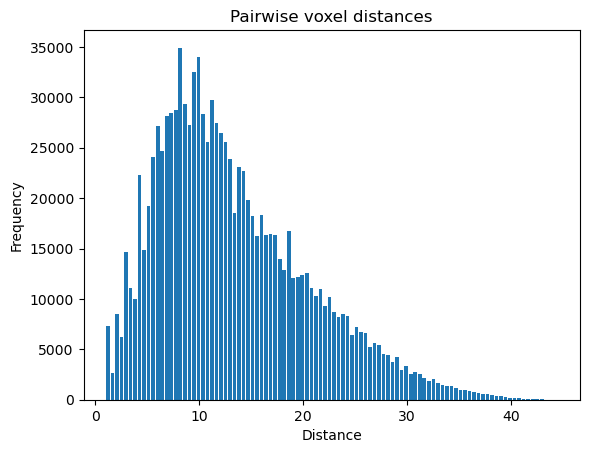

In [15]:
dist_all = plot_coord_dist(coordinates)

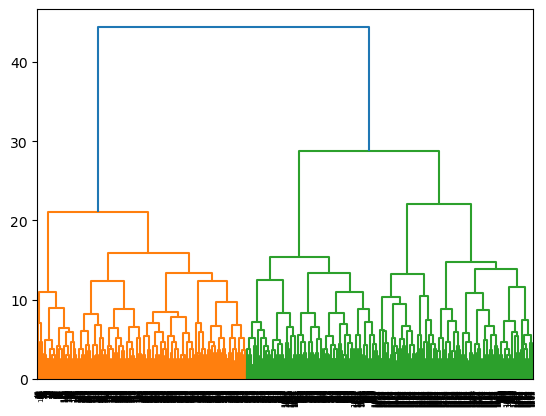

In [3]:

# Create a linkage matrix using the complete method
linkage_matrix = linkage(coordinates, method='complete')

# Plot the dendrogram
dendrogram(linkage_matrix)
plt.show()

In [55]:
def kl_by_threshold(
        linkage_matrix: np.ndarray, thresh: np.ndarray, coords: np.ndarray,
        bins: np.ndarray):
    clust_list = [0] * len(thresh)
    reps_list = [0] * len(thresh)
    hists_list = [0] * len(thresh)
    for i, t in enumerate(thresh):
        clusters = fcluster(linkage_matrix, t=t, criterion='distance')
        clust_list[i] = clusters

        reps_list[i] = dict()

        # Loop through each unique cluster label
        for cluster_label in np.unique(clusters):
            cluster_indices = np.where(clusters == cluster_label)[0]
            # Choose the first point in this cluster as the representative
            representative = cluster_indices[0]
            reps_list[i][cluster_label] = representative

        dist_trunc = pair_dist(coords[list(reps_list[i].values())])

        hist_trunc, _ = histogram(dist_trunc, bins=bins, density=True)
        hist_trunc += 1e-7
        hists_list[i] = hist_trunc
    return clust_list, reps_list, hists_list, thresh

In [56]:
hist_all, bins_all = histogram(dist_all, bins=100, density=True)
hist_all += 1e-7
clust_list, reps_list, hists_list, thresh_list =\
    kl_by_threshold(linkage_matrix, [2,3,4,5], coordinates, bins_all)

In [57]:
print(list(map(lambda clust: len(set(clust)), clust_list)))

[395, 201, 134, 89]


In [47]:
list(map(lambda hist_trunc: entropy(hist_all, hist_trunc), hists_list))

[0.00184070104383219,
 0.0072763406858623704,
 0.013738007830881256,
 0.026077711849218973]

/tmp/ipykernel_571285/1755362170.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(hists_list))


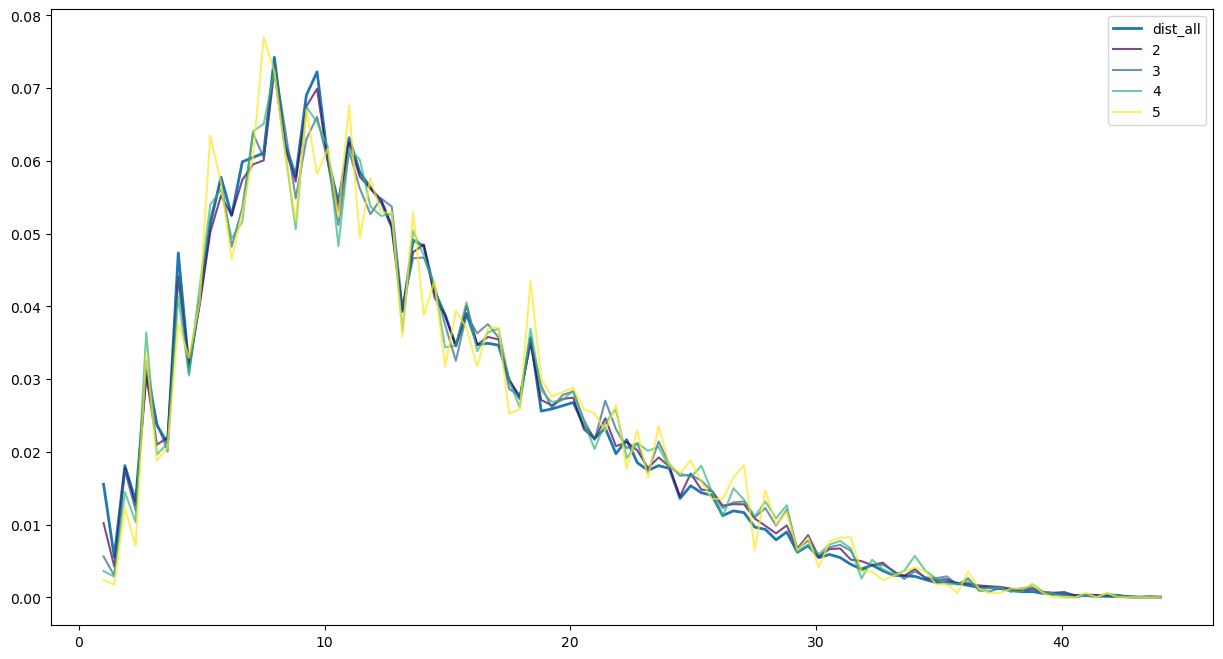

In [54]:
# Import colormap
from matplotlib import cm

# Create a colormap
cmap = cm.get_cmap('viridis', len(hists_list))

# Increase the figure size
plt.figure(figsize=(15, 8))

# Plot the distributions
plt.plot(bins_all[:-1], hist_all, label='dist_all', linewidth=2)

# Plot each histogram with a different color and line style
for i, hist_trunc in enumerate(hists_list):
    plt.plot(bins_all[:-1], hist_trunc, label=thresh_list[i], color=cmap(i), alpha=0.7)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [59]:
clust_list, reps_list, hists_list, thresh_list =\
    kl_by_threshold(linkage_matrix, np.arange(1, 5.1, 0.1), coordinates, bins_all)

In [ ]:
nclust_rand = []
nclust_kl = []
for nclust in np.arange(100, 800, 50):
    for _ in range(1, 51):
        rand_coords = coordinates[np.random.choice(coordinates.shape[0], nclust, replace=False)]
        dist_rand = pair_dist(rand_coords)
        hist_rand, _ = histogram(dist_rand, bins=bins_all, density=True)
        hist_rand += 1e-7
        nclust_rand.append(nclust)
        nclust_kl.append(entropy(hist_all, hist_rand))

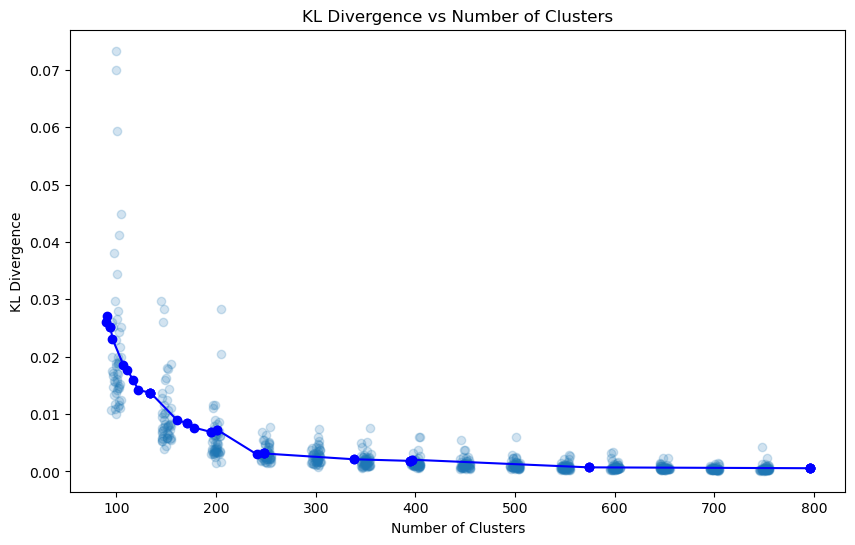

In [85]:
kl_list = list(map(lambda hist_trunc: entropy(hist_all, hist_trunc), hists_list))
num_clust = list(map(lambda clust: len(set(clust)), clust_list))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(num_clust, kl_list, marker='o', linestyle='-', color='b')
# Add a small jitter to the x-axis
jitter = 10*np.random.rand(len(nclust_rand)) - 5  # Jitter in the range [-0.005, 0.005]
plt.scatter(nclust_rand + jitter, nclust_kl, alpha=0.2)

# Add labels and title
plt.xlabel('Number of Clusters')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs Number of Clusters')

# Show the plot
plt.show()